In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

#from sklearn import preprocessing as pp
#from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
import re
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

#import torchvision.transforms as transforms
import torch.optim as optimizers
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler, BatchSampler

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
set_seed(123)

In [4]:
all_new = pd.read_csv('data/feature_df.csv')
wordvec_df = pd.read_csv('sub_notebook/data/wordvectorized_df.csv')
bert_embeded = pd.read_csv('data/bert_embeded.csv')
bert_svd256 = pd.read_csv("data/bert_svd256.csv")
ALBERT_svd256 = pd.read_csv("data/ALBERT_svd256.csv")
ROBERTA_svd256 = pd.read_csv("data/ROBERTA_svd256.csv")
XLMROBERTA_svd256 = pd.read_csv("data/XLMROBERTA_svd256.csv")
tfidf_svd_raw_64 = pd.read_csv("data/tfidf_svd_raw_64.csv")
mfw_df = pd.read_csv('data/mfw.csv')
miw_df = pd.read_csv('data/miw.csv')

In [5]:
#all_new = pd.merge(all_new, bert_embeded, on="id", how="outer")
all_new = pd.merge(all_new, XLMROBERTA_svd256, on="id", how="outer")
all_new = pd.merge(all_new, tfidf_svd_raw_64, on="id", how="outer")
all_new = pd.merge(all_new, wordvec_df, on="id", how="outer")
all_new = pd.merge(all_new, miw_df, on="id", how="outer")
all_new = pd.merge(all_new, mfw_df.drop(["mfw", "sfw"], axis=1), on="id", how="outer")
feature_cols = bert_embeded.columns.drop("id")

In [6]:
test_data = all_new[all_new["data_type"] == "test"]
train_data = all_new[all_new["data_type"] == "train"]

In [7]:
with open("data/nn_optuna_config_xlmroberta256.json") as f:
    optuna_config_dict = json.load(f)

target_cols = ["state"]
feature_cols = optuna_config_dict["selected_feature"]
CATEGORICAL_COLS = [
    "country",
    "category1",
    "category2",
    "country+category1",
    "country+category2",
    "category1+category2",
]

for categorical_col in CATEGORICAL_COLS:
    if categorical_col in feature_cols:
        feature_cols.remove(categorical_col)

In [8]:
def check_nan_columns(df, feature_cols):
    col_nan = set(np.where(np.isnan(np.array(df[feature_cols])) ==True)[1])
    col_names = df[feature_cols].columns
    col_nan = col_names[list(col_nan)]
    print(f"there are {len(col_nan)} columns including np.nan")
    print(f"{list(col_nan)}")
    
    for col in col_nan:
        feature_cols.remove(col)
        
    return feature_cols

In [9]:
feature_cols = check_nan_columns(all_new, feature_cols)

there are 0 columns including np.nan
[]


In [10]:
class CFDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.feature_cols = feature_cols
        self.target_cols = target_cols
        
        
    def __len__(self):
        return len(self.csv_file)
    
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        features = self.csv_file[self.feature_cols].iloc[idx]
        features = torch.FloatTensor(features)
        
        target = self.csv_file[self.target_cols].iloc[idx]
        target = torch.tensor(target)
        
        if self.transform:
            features = self.transform(features)
            
        return features, target

In [11]:
class CFDataModule(pl.LightningDataModule):
    def __init__(self, train, validation, transform, batch_size, num_workers):
        super().__init__()
        self.csv_file = train
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.validation = validation
        

    def setup(self, stage=None):
        self.train_dataset = CFDataset(csv_file=self.csv_file, transform=self.transform)
        self.val_dataset = CFDataset(csv_file=self.validation, transform=self.transform)
            
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          drop_last=True,
                          num_workers=self.num_workers,
                          pin_memory=True)
    
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.batch_size,
                          drop_last=False,
                          num_workers=self.num_workers,
                          pin_memory=True)

In [12]:
class CFModule(pl.LightningModule):
    def __init__(self, input_dim, hidden_sizes, out_dim, dropout):
        super(CFModule, self).__init__()
        self.layers = []
        self.dropouts = []
        self.dense_layers = []
        
        for hidden_size in hidden_sizes:
            self.layers.append(nn.BatchNorm1d(input_dim))
            self.dropouts.append(nn.Dropout(dropout))
            self.dense_layers.append(nn.utils.weight_norm(nn.Linear(input_dim, hidden_size)))
            input_dim = hidden_size
        self.layers.append(nn.Linear(input_dim, out_dim))
        
        for idx, layer in enumerate(self.layers):
            setattr(self, "fc{}".format(idx), layer)

        for idx, dropout in enumerate(self.dropouts):
            setattr(self, "drop{}".format(idx), dropout)
            
        for idx, dense in enumerate(self.dense_layers):
            setattr(self, "dense{}".format(idx), dense)

    
    def forward(self, x):
        for batch_norm, dropout, dense in zip(self.layers, self.dropouts, self.dense_layers):
            x = batch_norm(x)
            x = dropout(x)
            x = F.relu(dense(x))    
        x = self.layers[-1](x)
        
        return torch.sigmoid(x)
    
    
    def training_step(self, batch, batch_idx):
        x, t = batch
        pred = self.forward(x)
        loss = self.criterion(pred, t)
        acc = self.metric(pred, t)
        # you should define log as {"tag_name/log_name"}
        tensorboard_logs = {'train/train_loss': loss, "train/train_acc": acc}
        return {"loss": loss, "acc": acc, "logs": tensorboard_logs, "progress_bar": tensorboard_logs}
    
    
    def validation_step(self, batch, batch_idx):
        x, t = batch
        pred = self.forward(x)
        loss = self.criterion(pred, t)
        acc = self.metric(pred, t)
        logs = {"val_loss": loss, "val_acc": acc}
        self.log("val_loss", loss)
        return {"val_loss": loss, "val_acc": acc, "progress_bar": logs}

    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([torch.tensor(x['val_acc']) for x in outputs]).mean()
        tensorboard_logs = {'val/avg_loss': avg_loss, "val/avg_acc": avg_acc}
        print(f"val_loss: {avg_loss}, val_acc: {avg_acc}")
        # you should call back as name "val_loss" to using the Early-Stopping
        return {'val_loss': avg_loss, "val_acc": avg_acc, 'log': tensorboard_logs}
    
    
    def test_step(self, batch, batch_idx):
        x, t = batch
        pred = self.forward(x)
        return {"preds": pred}
    
    
    def test_epoch_end(self, outputs):
        preds = torch.cat([x["preds"] for x in outputs], dim=0).squeeze()
        preds = np.array(preds.tolist())
        return {"preds": preds}
    
    
    def configure_optimizers(self):
        optimizer = optimizers.Adam(self.parameters(), 
                                    lr=0.01, betas=(0.9,0.999),
                                    eps=1e-08, weight_decay=0, amsgrad=False)
        scheduler = {"scheduler": 
                     optimizers.lr_scheduler.CosineAnnealingLR(
                        optimizer, T_max=10),
                    "interval": "epoch",
                    "monitor": "val_loss"}
        return [optimizer], [scheduler]
    
    
    def criterion(self, pred, t):
        #pred = pred.view(-1)
        pred = pred.float()
        t = t.float()
        #return F.binary_cross_entropy(input=pred, target=t)
        return F.mse_loss(input=pred, target=t)
    
    
    def metric(self, pred, t):
        t = t.to('cpu')
        pred = np.array(pred.tolist())
        pred = np.where(pred<0.5, 0, 1)
        return f1_score(y_true=t, y_pred=pred, average='binary', sample_weight=None, zero_division='warn')

In [13]:
def add_cols_kfold(n_folds, train, y_train, seed):
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    for fold, (t_idx, v_idx) in enumerate(cv.split(train, y_train)):
        train.loc[v_idx, 'kfold'] = int(fold)
        
    return train

In [14]:
def main():
    # trainer config
    max_epochs = 100
    output_path = './exp_003/'
    
    # data module config
    #train_set
    transform = None
    batch_size = 256*8
    num_workers = 3
    
    # model config
    params = optuna_config_dict["best_params"]
    n_layers = params["n_layers"]
    dropout = params["dropout"]
    hidden_sizes = [0]*n_layers
    for n in range(n_layers):
        hidden_sizes[n] = params[f"n_units_l{n}"]
    input_dim = len(feature_cols)
    out_dim = 1
    
    # early stopping config
    patience = 4
    
    # kfold config
    n_folds = 5
    seed = 1111
    
    config_dict = {
        "max_epochs": max_epochs,
        "output_path": output_path,
        "batch_size": batch_size,
        "num_workers": num_workers,
        "optuna_config" : optuna_config_dict,
        "patience": patience,
        "n_folds": n_folds,
        "seed": seed 
    }
    
    # prepare data for with kfold
    train = add_cols_kfold(n_folds=n_folds,
                            train=train_data,
                           y_train=train_data["category2"],
                            seed=seed)
    
    test_prediction = []
    oof_train = np.zeros((len(train_data),))
    for fold in train.kfold.unique():
        train_fold = train[train["kfold"] != fold]
        val_fold = train[train["kfold"] == fold]
        val_idx = val_fold.index
    
        cf = CFDataModule(train_fold, val_fold, transform, batch_size, num_workers)
        model = CFModule(input_dim=input_dim, hidden_sizes=hidden_sizes, out_dim=out_dim, dropout=dropout)

        early_stopping = EarlyStopping('val_loss', patience=patience, verbose=True)
        trainer = Trainer(
            max_epochs=max_epochs,
            weights_save_path=output_path,
            gpus = 1 if torch.cuda.is_available() else None,
            callbacks=[early_stopping],
            #accumulate_grad_batches=1
            # use_amp=False,
            )
        
        # training
        trainer.fit(model, cf)
        
        # oof prediction
        oof_dataset = CFDataset(val_fold)
        oof_dataloader = DataLoader(oof_dataset,
                                    batch_size=batch_size,
                                    drop_last=False,
                                    shuffle=False,
                                    num_workers=num_workers,
                                    pin_memory=True)
        oof_results = trainer.test(test_dataloaders=oof_dataloader, verbose=False)
        oof_train[val_idx] = oof_results[0]["preds"]
        
        # test prediction
        test_dataset = CFDataset(test_data)
        test_dataloader = DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    drop_last=False,
                                     shuffle=False,
                                    num_workers=num_workers,
                                    pin_memory=True)
        test_results = trainer.test(test_dataloaders=test_dataloader, verbose=False)
        test_preds = test_results[0]["preds"]
        test_prediction.append(test_preds)
        torch.cuda.empty_cache()
        
    return oof_train, sum(test_prediction)/len(test_prediction), config_dict

In [15]:
if __name__ == "__main__":
    oof, preds, config_dict = main()

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | fc0    | BatchNorm1d | 622   
1 | fc1    | BatchNorm1d | 86    
2 | fc2    | Linear      | 13    
3 | drop0  | Dropout     | 0     
4 | drop1  | Dropout     | 0     
5 | dense0 | Linear      | 13.5 K
6 | dense1 | Linear      | 540   
---------------------------------------
14.7 K    Trainable params
0         Non-trainable params
14.7 K    Total params


val_loss: 0.5128874182701111, val_acc: 0.6442114423454575


val_loss: 0.20143458247184753, val_acc: 0.6614158971573421


val_loss: 0.17590045928955078, val_acc: 0.7651280815222485


val_loss: 0.1723645031452179, val_acc: 0.7806924989388151


val_loss: 0.1734435260295868, val_acc: 0.7810498309276417


val_loss: 0.17566171288490295, val_acc: 0.7780233573455577


val_loss: 0.17545513808727264, val_acc: 0.7761718750000001


val_loss: 0.17215898633003235, val_acc: 0.7679815910585142


val_loss: 0.16875889897346497, val_acc: 0.7808000000000002


val_loss: 0.16573846340179443, val_acc: 0.7904822703928955


val_loss: 0.16306474804878235, val_acc: 0.7924013215093026


val_loss: 0.16047558188438416, val_acc: 0.7899661855769173


val_loss: 0.15797331929206848, val_acc: 0.7827071659549258


val_loss: 0.1555880755186081, val_acc: 0.7774704615266961


val_loss: 0.15346243977546692, val_acc: 0.7799632329309525


val_loss: 0.1520240604877472, val_acc: 0.7967269259958357


val_loss: 0.15231165289878845, val_acc: 0.7926105025525256


val_loss: 0.15286311507225037, val_acc: 0.7807917505293149


val_loss: 0.15347875654697418, val_acc: 0.7848248661846182


val_loss: 0.1517452597618103, val_acc: 0.7921577057306155


val_loss: 0.15168140828609467, val_acc: 0.8033797974784678


val_loss: 0.1524985432624817, val_acc: 0.8027144028554891


val_loss: 0.15607081353664398, val_acc: 0.7992159885348862


val_loss: 0.15484164655208588, val_acc: 0.8026397762114753


val_loss: 0.15567618608474731, val_acc: 0.7949956101843723



EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | fc0    | BatchNorm1d | 622   
1 | fc1    | BatchNorm1d | 86    
2 | fc2    | Linear      | 13    
3 | drop0  | Dropout     | 0     
4 | drop1  | Dropout     | 0     
5 | dense0 | Linear      | 13.5 K
6 | dense1 | Linear      | 540   
---------------------------------------
14.7 K    Trainable params
0         Non-trainable params
14.7 K    Total params


val_loss: 0.5247462391853333, val_acc: 0.0


val_loss: 0.21464139223098755, val_acc: 0.5817579771222156


val_loss: 0.18753424286842346, val_acc: 0.7422427035330261


val_loss: 0.1757078766822815, val_acc: 0.7951953573115595


val_loss: 0.1787639856338501, val_acc: 0.777389473041647


val_loss: 0.17852574586868286, val_acc: 0.7803880371289516


val_loss: 0.17485424876213074, val_acc: 0.7676624463743853


val_loss: 0.17245563864707947, val_acc: 0.7919125866308965


val_loss: 0.1709333062171936, val_acc: 0.7989808539623007


val_loss: 0.1690148115158081, val_acc: 0.7995076147944578


val_loss: 0.16685707867145538, val_acc: 0.806996606996607


val_loss: 0.16464704275131226, val_acc: 0.8069515568897523


val_loss: 0.16254638135433197, val_acc: 0.8055535257581293


val_loss: 0.16094334423542023, val_acc: 0.8034820952483659


val_loss: 0.15973792970180511, val_acc: 0.8052200198334468


val_loss: 0.15917888283729553, val_acc: 0.7956819866567828


val_loss: 0.1586608588695526, val_acc: 0.7906265802418057


val_loss: 0.1583845317363739, val_acc: 0.7855345168319172


val_loss: 0.1609112024307251, val_acc: 0.7801355668767809


val_loss: 0.15933577716350555, val_acc: 0.7996412263535551


val_loss: 0.15853871405124664, val_acc: 0.8073003915877979


val_loss: 0.15987254679203033, val_acc: 0.7973548508319588



EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | fc0    | BatchNorm1d | 622   
1 | fc1    | BatchNorm1d | 86    
2 | fc2    | Linear      | 13    
3 | drop0  | Dropout     | 0     
4 | drop1  | Dropout     | 0     
5 | dense0 | Linear      | 13.5 K
6 | dense1 | Linear      | 540   
---------------------------------------
14.7 K    Trainable params
0         Non-trainable params
14.7 K    Total params


val_loss: 0.40497326850891113, val_acc: 0.5238972200298168


val_loss: 0.20294947922229767, val_acc: 0.6781996813595327


val_loss: 0.18285977840423584, val_acc: 0.7282488753076989


val_loss: 0.17687179148197174, val_acc: 0.7721535679300731


val_loss: 0.17452414333820343, val_acc: 0.761234071093226


val_loss: 0.172804594039917, val_acc: 0.7638091443837735


val_loss: 0.17099440097808838, val_acc: 0.7659873864098738


val_loss: 0.16887512803077698, val_acc: 0.7797828638497653


val_loss: 0.16630220413208008, val_acc: 0.7877894736842106


val_loss: 0.16383770108222961, val_acc: 0.7813299232736572


val_loss: 0.16133205592632294, val_acc: 0.7891902545713487


val_loss: 0.15887689590454102, val_acc: 0.7720023198492096


val_loss: 0.1566893309354782, val_acc: 0.7722880983750549


val_loss: 0.15471762418746948, val_acc: 0.7678009950248756


val_loss: 0.15281592309474945, val_acc: 0.7904447702834799


val_loss: 0.15057939291000366, val_acc: 0.7952753240599724


val_loss: 0.1488816738128662, val_acc: 0.8143673038196164


val_loss: 0.14780530333518982, val_acc: 0.8074249090217804


val_loss: 0.1466532051563263, val_acc: 0.7855608583643559


val_loss: 0.14640545845031738, val_acc: 0.7896484140634374


val_loss: 0.1488894671201706, val_acc: 0.7907647907647908


val_loss: 0.14884963631629944, val_acc: 0.7981981981981983


val_loss: 0.14913779497146606, val_acc: 0.7952889120249871


val_loss: 0.1492632031440735, val_acc: 0.7906932262207285



EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | fc0    | BatchNorm1d | 622   
1 | fc1    | BatchNorm1d | 86    
2 | fc2    | Linear      | 13    
3 | drop0  | Dropout     | 0     
4 | drop1  | Dropout     | 0     
5 | dense0 | Linear      | 13.5 K
6 | dense1 | Linear      | 540   
---------------------------------------
14.7 K    Trainable params
0         Non-trainable params
14.7 K    Total params


val_loss: 0.38892799615859985, val_acc: 0.6769826875515251


val_loss: 0.20347526669502258, val_acc: 0.6896299189532271


val_loss: 0.19069355726242065, val_acc: 0.7566497929130234


val_loss: 0.19477714598178864, val_acc: 0.7666342096721843


val_loss: 0.19808432459831238, val_acc: 0.7631367706082124


val_loss: 0.19708029925823212, val_acc: 0.7526626548818343


val_loss: 0.19424167275428772, val_acc: 0.7577558804831532



EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | fc0    | BatchNorm1d | 622   
1 | fc1    | BatchNorm1d | 86    
2 | fc2    | Linear      | 13    
3 | drop0  | Dropout     | 0     
4 | drop1  | Dropout     | 0     
5 | dense0 | Linear      | 13.5 K
6 | dense1 | Linear      | 540   
---------------------------------------
14.7 K    Trainable params
0         Non-trainable params
14.7 K    Total params


val_loss: 0.4758460819721222, val_acc: 0.2401902739781961


val_loss: 0.20469000935554504, val_acc: 0.6442814145974418


val_loss: 0.18399983644485474, val_acc: 0.7077047663118926


val_loss: 0.18363231420516968, val_acc: 0.75654817288451


val_loss: 0.19005662202835083, val_acc: 0.7312091503267972


val_loss: 0.19121496379375458, val_acc: 0.72430053102322


val_loss: 0.1900443434715271, val_acc: 0.7250083350361901


val_loss: 0.18762606382369995, val_acc: 0.7410153250489385



In [23]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.title('f1_score')
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.7732604852964808 0.42500000000000004


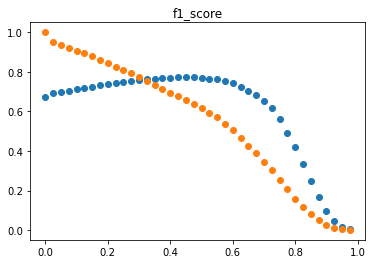

In [17]:
best_score, best_threshold = optimize_threshold(oof, list(train_data["state"]))
print(best_score, best_threshold)

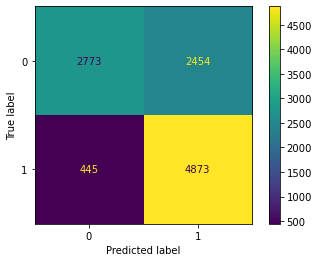

In [18]:
cm = confusion_matrix(list(train_data["state"]), np.where(oof<0.4, 0, 1))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [19]:
def making_sub(preds, threshold):
    preds = np.where(preds<threshold, 0, 1)
    
    df = pd.DataFrame(columns=["id", "state"])
    df["state"] = preds
    df["id"] = range(10545, 21089)
    return df

<AxesSubplot:>

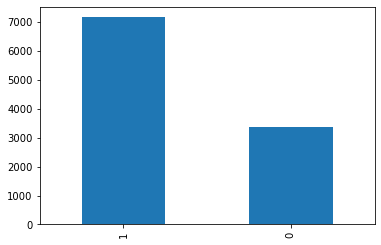

In [20]:
sub_file = making_sub(preds, best_threshold)
sub_file.to_csv(f"./sub_files/optuna_nn_sub_{5}.csv", index=False, header=False)
plt.figure()
sub_file["state"].value_counts().plot(kind="bar")

In [21]:
config_dict["selected_feature"] = list(feature_cols)
config_dict["out_of_fold"] = list(oof)
config_dict["prediction"] = list(preds)

In [22]:
with open("data/nn_config_xlmrobert256_mseloss.json", 'w') as f:
    json.dump(config_dict, f)